In [30]:
import sys
import os
# Add parent directory to path for utils imports
if os.path.dirname(os.path.abspath('')) not in sys.path:
    sys.path.insert(0, os.path.dirname(os.path.abspath('')))

import pandas as pd
import numpy as np
from utils.io import load_data, load_pairs
from utils.config import get_stock_data_path

data = load_data(get_stock_data_path())
pairs = load_pairs('../analysis/cointegrated_pairs.pkl')
print(pairs)

def compute_spread(df, t1, t2, hedge_ratio):
  col1 = f"Close__{t1}"
  col2 = f"Close__{t2}"
  return np.log(df[col1]) - hedge_ratio * np.log(df[col2])

spread = compute_spread(data, pairs[0]['tickers'][0], pairs[0]['tickers'][1], pairs[0]['hedge_ratio'])

# Calculate z-score
z = (spread - spread.rolling(window=30).mean()) / spread.rolling(window=30).std()

# Debug: Check z-score range
print(f"Z-score range: [{z.min():.2f}, {z.max():.2f}]")
print(f"Z-score mean: {z.mean():.2f}, std: {z.std():.2f}")
print(f"Values > 2: {(z > 2).sum()}, Values < -2: {(z < -2).sum()}")

# Generate position signals with proper mean-reversion logic
# Entry: z > 2 → short, z < -2 → long
# Exit: z crosses back to 0 or hits opposite threshold
position = pd.Series(0, index=z.index, dtype=float)

current_pos = 0
for i in range(len(z)):
    if pd.isna(z.iloc[i]):
        position.iloc[i] = 0
    elif z.iloc[i] > 2:
        current_pos = -1  # Short when spread too high
    elif z.iloc[i] < -2:
        current_pos = 1   # Long when spread too low
    elif abs(z.iloc[i]) < 0.5:  # Exit when z returns near 0
        current_pos = 0
    position.iloc[i] = current_pos

print(f"\nPosition distribution:")
print(position.value_counts())
print(f"\nFirst 50 positions:\n{position.head(50)}")
print(f"Number of position changes: {(position.diff() != 0).sum()}")


[{'pvalue': np.float64(3.982765594908068e-05), 'adf_statistic': np.float64(-4.870292784698115), 'tickers': ('V', 'SAP'), 'intercept': np.float64(3.0223709663822653), 'hedge_ratio': np.float64(0.49318084776788407), 'r_squared': np.float64(0.9101503781430106)}, {'pvalue': np.float64(0.00010077628258053696), 'adf_statistic': np.float64(-4.65816046554146), 'tickers': ('MA', 'SAP'), 'intercept': np.float64(3.506812541044674), 'hedge_ratio': np.float64(0.4959623739495811), 'r_squared': np.float64(0.9044298489479443)}, {'pvalue': np.float64(0.000356970828700056), 'adf_statistic': np.float64(-4.354506580128591), 'tickers': ('V', 'MA'), 'intercept': np.float64(-0.3595804183178686), 'hedge_ratio': np.float64(0.9768017802949576), 'r_squared': np.float64(0.9710379570228973)}, {'pvalue': np.float64(0.0008713811156952654), 'adf_statistic': np.float64(-4.127677303102999), 'tickers': ('AAPL', 'ANET'), 'intercept': np.float64(3.9115707770017174), 'hedge_ratio': np.float64(0.32276932923513013), 'r_squar

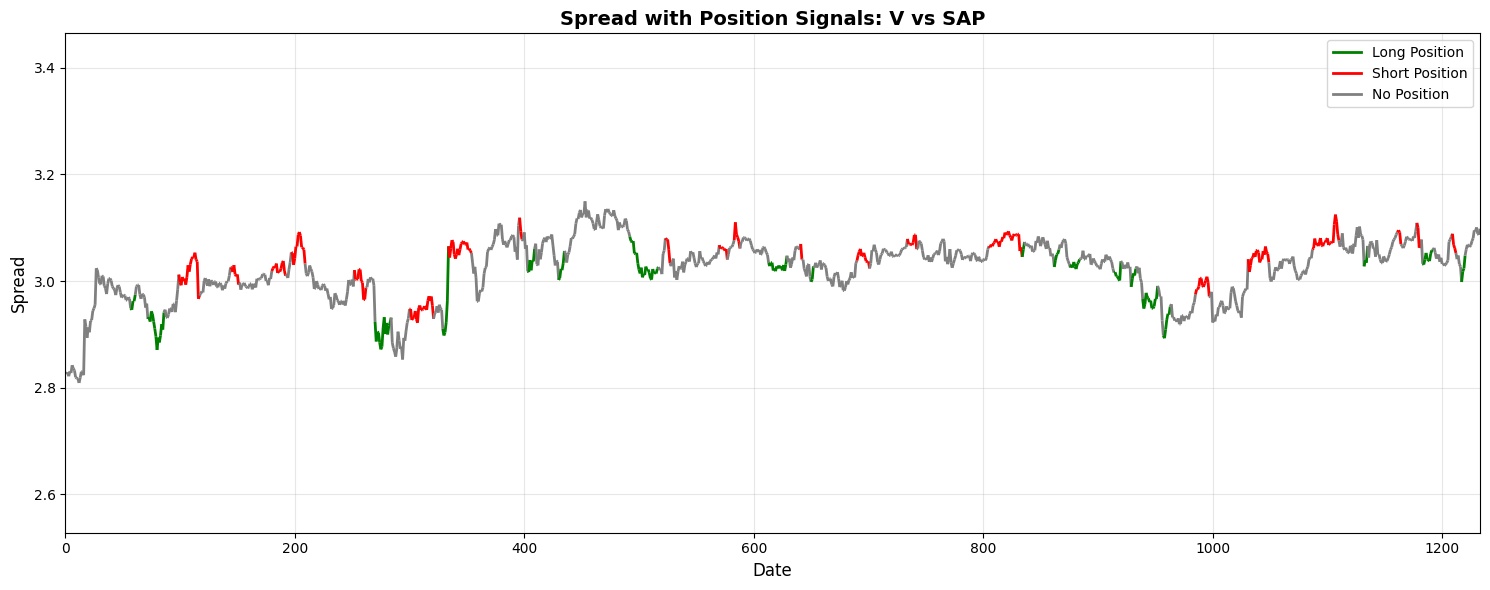

In [31]:
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll

def plot_spread_with_signals(spread, position, title="Spread with Position Signals"):
    """Plot spread colored by position signals (green=long, red=short, gray=neutral)"""
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Create segments for line collection
    points = np.array([spread.index, spread.values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Color map: 1=green (long), -1=red (short), 0=gray (neutral)
    colors = []
    for pos in position[:-1]:
        if pos == 1:
            colors.append('green')
        elif pos == -1:
            colors.append('red')
        else:
            colors.append('gray')
    
    # Create line collection with colored segments
    lc = mcoll.LineCollection(segments, colors=colors, linewidths=2)
    ax.add_collection(lc)
    
    # Set axis limits
    ax.set_xlim(spread.index.min(), spread.index.max())
    ax.set_ylim(spread.min() * .9, spread.max() * 1.1)
    
    # Labels and title
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Spread', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='Long Position'),
        Line2D([0], [0], color='red', lw=2, label='Short Position'),
        Line2D([0], [0], color='gray', lw=2, label='No Position')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Plot the spread with position signals
pair_name = f"{pairs[0]['tickers'][0]} vs {pairs[0]['tickers'][1]}"
plot_spread_with_signals(spread, position, f"Spread with Position Signals: {pair_name}")



BACKTEST RESULTS: V vs SAP
Sharpe Ratio:      1.6664
Total Return:      167.29%
Max Drawdown:      -8.25%
Number of Trades:  78
Win Rate:          49.52%


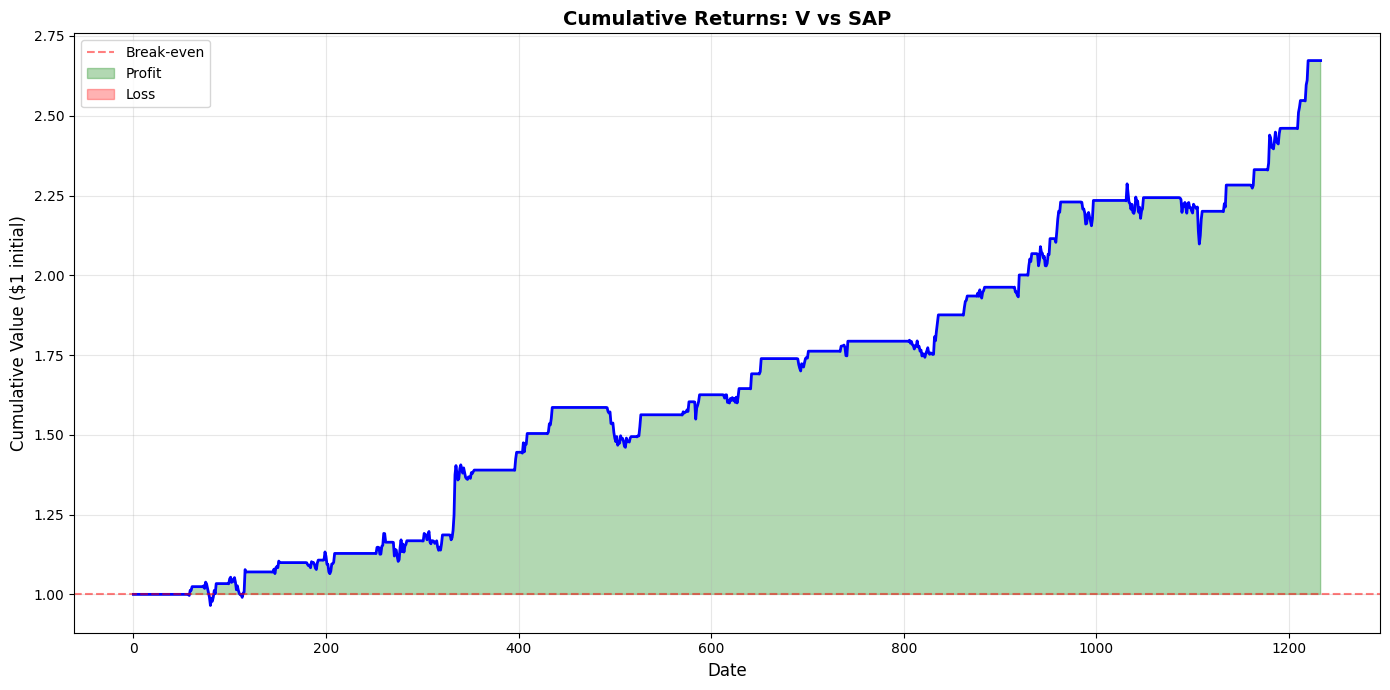

In [32]:
def backtest_pairs(spread, position, cost=0.0005):
    """
    Backtest pairs trading strategy
    Position: 1 = long spread, -1 = short spread
    Returns are based on spread changes (already in log form)
    """
    # Spread returns (log differences)
    spread_returns = spread.diff()
    
    # P&L = position * spread_returns - transaction costs
    # Transaction costs occur when position changes
    position_changes = position.diff().abs()
    transaction_costs = cost * position_changes
    
    # Daily P&L
    daily_pnl = position.shift(1) * spread_returns - transaction_costs
    daily_pnl = daily_pnl.fillna(0)
    
    # Cumulative returns
    cumulative = (1 + daily_pnl).cumprod()
    
    # Performance metrics
    sharpe = daily_pnl.mean() / daily_pnl.std() * np.sqrt(252) if daily_pnl.std() > 0 else 0
    total_return = cumulative.iloc[-1] - 1
    
    # Drawdown calculation
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Additional metrics
    num_trades = (position_changes > 0).sum()
    win_rate = (daily_pnl[daily_pnl != 0] > 0).sum() / len(daily_pnl[daily_pnl != 0]) if len(daily_pnl[daily_pnl != 0]) > 0 else 0
    
    return {
        "Sharpe": sharpe,
        "TotalReturn": total_return,
        "MaxDrawdown": max_drawdown,
        "NumTrades": num_trades,
        "WinRate": win_rate,
        "Cumulative": cumulative,
        "DailyPnL": daily_pnl,
        "Drawdown": drawdown
    }

results = backtest_pairs(spread, position, cost=0.0005)
print(f"\n{'='*50}")
print(f"BACKTEST RESULTS: {pair_name}")
print(f"{'='*50}")
print(f"Sharpe Ratio:      {results['Sharpe']:.4f}")
print(f"Total Return:      {results['TotalReturn']:.2%}")
print(f"Max Drawdown:      {results['MaxDrawdown']:.2%}")
print(f"Number of Trades:  {results['NumTrades']}")
print(f"Win Rate:          {results['WinRate']:.2%}")
print(f"{'='*50}")

# Plot cumulative returns
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(results['Cumulative'].index, results['Cumulative'].values, linewidth=2, color='blue')
ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Break-even')
ax.fill_between(results['Cumulative'].index, 1, results['Cumulative'].values, 
                 where=(results['Cumulative'].values >= 1), alpha=0.3, color='green', label='Profit')
ax.fill_between(results['Cumulative'].index, 1, results['Cumulative'].values, 
                 where=(results['Cumulative'].values < 1), alpha=0.3, color='red', label='Loss')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Value ($1 initial)', fontsize=12)
ax.set_title(f'Cumulative Returns: {pair_name}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()
